---
authors:
  - name: "John B. DeSanto"
    id: johnbdesanto
    affiliations:
      - id: uw-ess
    orcid: "0000-0003-4997-364X"
    github: johnbdesanto
---

# Exercise 3: GNSS-Acoustic Metadata

GNSS-A is a powerful tool for positioning the seafloor, but it requires precise information from a number of outside sources in order to properly function. This exercise is meant to help users explore the metadata required to position a GNSS-A array, and will cover the following topics:

* Time delays of the seafloor transponders and sea surface transducer
* The sound velocity profile of the water column
* Transponder *a priori* positions

This exercise will have multiple sections that explore these topics by modifying the metadata of a pre-processed GNSS-A survey, the 2024 survey of the NCB1 array offshore Coos Bay, OR, collected as part of the Near Trench Community Geodesy Experiment. We encourage users to modify the input files for this exercise, and have provided a backup copy of necessary files so that any changes users make throughout this exercise may be easily reverted.

As a quick review, you can easily process data in the community standard GNSS-A data format using the `--solver` module of GNATSS. GNATSS automatically generates data in this format with the `--posfilter` module during pre-processing and saves it in the file `gps_solution.csv` in the user-specified output directory. In order to process a `gps_solution.csv` file given a configuration file and ctd, run the following commands:

In [1]:
from gnatss.main import run_gnatss

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...
--- 27243 e

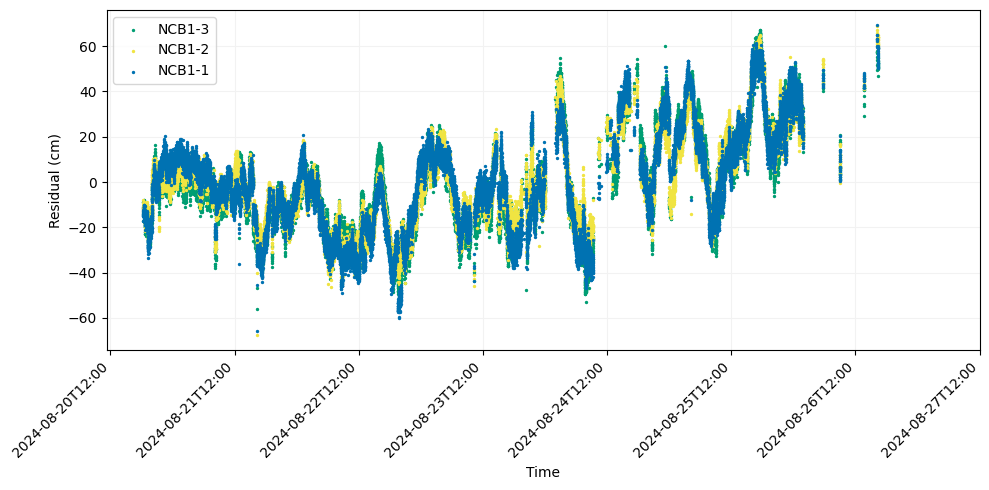

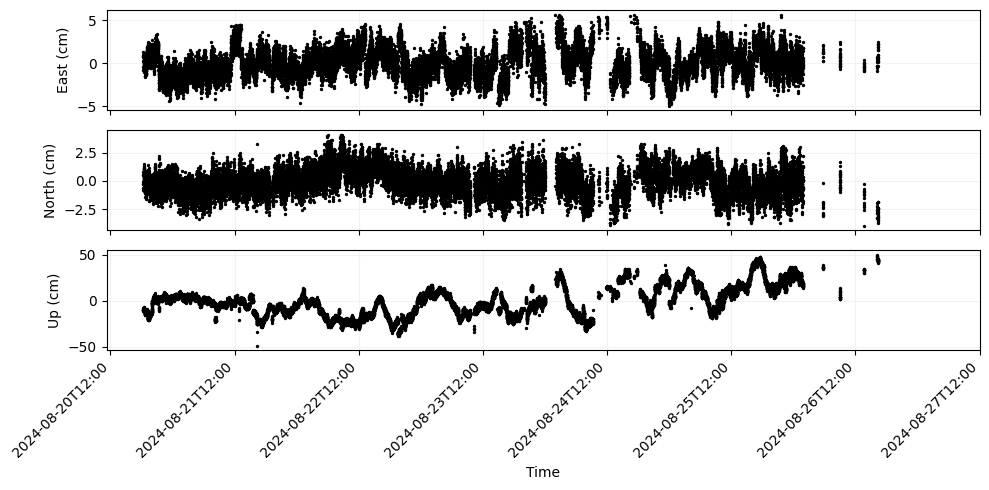

In [2]:
# Set input variables

config_yaml = "../data/exercise-3/NCB1_2024_config.yaml"
skip_posfilter = True

# Run GNATSS solver

output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

This solution will serve as the baseline for the exercises below. We have also provided a copy of this solution in the `../data/exercise-3/reference_solution` folder. We recommend opening the residual plots `reference_solution/residuals.png` and `residuals_enu_components.png` in the sidebar so that you can make a quick comparison as we change the metadata.

## Travel time delays

Perhaps the most critical piece of metadata required for GNSS-A processing is information about the timing delays introduced into the measurements by the instruments, since if these delays are not properly accounted for the user is liable to significantly overestimate the range to the transponders. While these time delays may not be larger than a few dozen milliseconds, consider that 1) the transducer records two-way travel times with microsecond precision, and 2) the speed of sound in seawater is large enough that 1 ms corresponds to approximately 1.5 meters travelled by an acoustic pulse. As a result, even minute discrepencies in the time delays assumed can lead to significant biases in the final solution.

There are two time delays we will consider, the time delay in the transponders (called the turn-around time or TAT) and the time delay in the transducer on the sea surface (also called the trigger delay).

### Turn-around Time

The TAT is a user-defined internal delay present in the seafloor transponders. It's purpose is to stagger the transponder replies so that they do not interfere when being recorded by the sea surface transducer. If you inspect the configuration file `../data/exercise-3/NCB1_2024_config.yaml` you will find the TATs logged for each transponder under the key `internal_delay`.

```
transponders: # list out all transponder and info, each entry is a different transponder (default: 3 transponders)
  - lat: 43.580175830 #decimal latitude
    lon: -125.097547806 #decimal longitude
    height: -1076.6562 #transponder depth (m, positive up)
    internal_delay: 0.08 #Transponder Turn-Around Time (s)
    sv_mean: 1481.683 #Estimate of mean sound velocity (m/s)
    pxp_id: NCB1-3
  - lat: 43.566349513 #decimal latitude
    lon: -125.097616709 #decimal longitude
    height: -1116.0454 #transponder depth (m, positive up)
    internal_delay: 0.36 #Transponder Turn-Around Time (s)
    sv_mean: 1486.696 #Estimate of mean sound velocity (m/s)
    pxp_id: NCB1-2
  - lat: 43.572747980 #decimal latitude
    lon: -125.115119432 #decimal longitude
    height: -1140.9439 #transponder depth (m, positive up)
    internal_delay: 0.64 #Transponder Turn-Around Time (s)
    sv_mean: 1481.705 #Estimate of mean sound velocity (m/s)
    pxp_id: NCB1-1
```


The TAT is assumed to be included in the acoustic TWTT measurements in the `gps_solution.csv` file since they occur in betwen the transducer sending an interrogation ping and receiving a reply, and GNATSS will automatically remove it before modelling the ray path between the transducer and transponder.

Let's go ahead and modify the configuration file. Set the TAT of the first transponder (NCB1-3) to `0.20`, the TAT of the second transponder (NCB1-2) to `0.32`, and the TAT of the third transponder (NCB1-1) to `0.44`. These delays have only been cahnged by a small fraction of a second, but if we re-run the solver we can see that this has made a large difference in the residual plot.

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.2 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.32 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.44 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...
--- 27243 ep

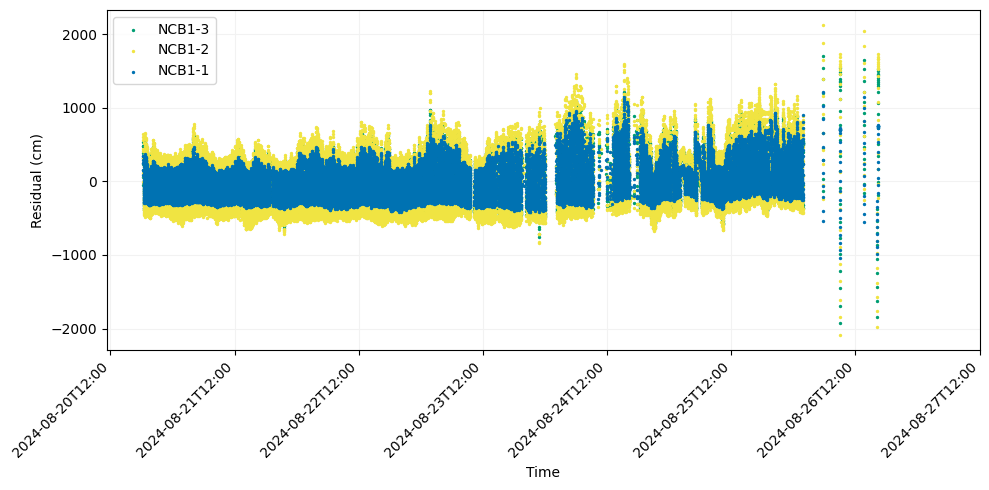

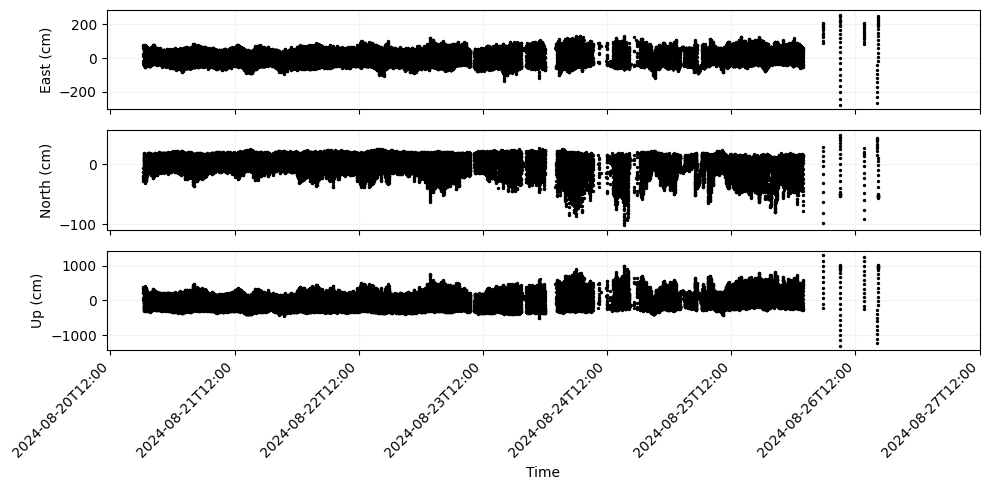

In [3]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

The residuals here are nearly illegible and the array offset is comically large, so it is clear that even though the changed time delays seemed small, their impact was significant.

To drive this point home, let us execute another example in which we only modify one of the TATs and by a smaller amount. Change the TAT values in the configuration file to `0.12` for NCB1-3, `0.36` for NCB1-2, and `0.64` for NCB1-1. These are the actual values for NCB1-2 and NCB1-1, which you can verify in the reference configuration file, and the TAT for NCB1-3 had only been increased by 0.04s (the smallest possible increment allowed by the Sonardyne transponders) from its actual value of 0.08s

Now, execute the solver again on this mostly corrected configuration file.

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.12 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...
--- 27243 e

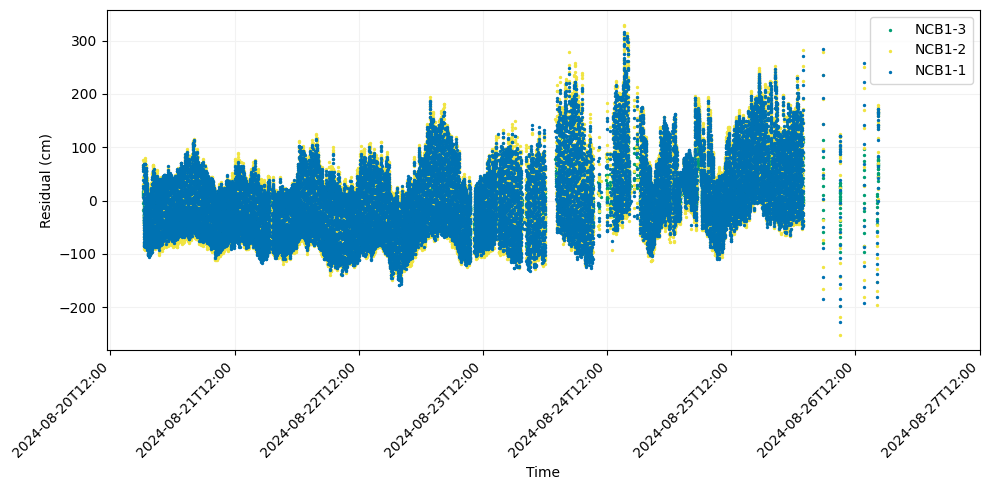

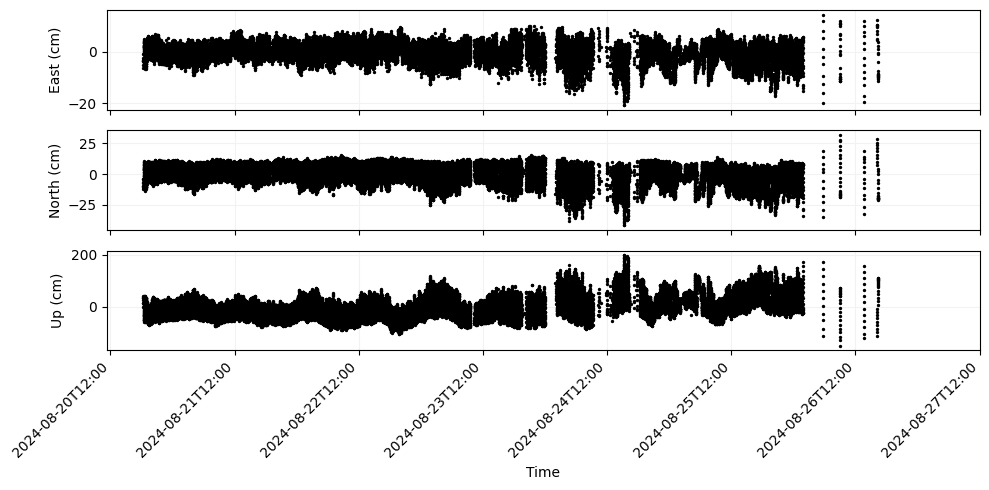

In [4]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

Perhaps amazingly, even though the metadata of only one transponder was modified the residuals for each transponder have still been pretty dramatically affected. And once again, the change was the smallest possible increment allowed by the transponders.

If there is a takeaway here, it is that it is critical to keep good notes on these metadata. The TAT is also logged in the raw data files recorded by the Wave Glider, so if for some reason you think a TAT value may be wrong in a configuration file you are using and you don't have access to a field log with that metadata recorded, it is possible to recover the needed information. However, acessing those raw data files is beyond the scope of this exercise.

Before moving on to the next exercise, be sure to correct the TAT input to their original values, those being `0.08` for NCB1-3, `0.36` for NCB1-2, and `0.64` for NCB1-1. If you are having trouble, refer to the sample text from the configuration file above or the `NCB1_2024_reference_config.yaml` file.

### Trigger Delay

The "trigger delay" refers to a transducer delay time that occurs between the computer sending a command to the transducer to emit an interrogation ping and the ping being emitted. This delay varies by surface platform, for the model SV-3 Wave Gliders used in the Near-trench Community Geodesy Experiment the trigger delay is 0.13 seconds. Although this time difference is minute, it is enough to ruin a GNSS-A inversion if not accounted for. 

Since the trigger delay occurs before the interrogation ping is emmitted, by convention GNATSS expects it to already be removed from TWTT measurements prior to any processing. If you inspect a configuration file, you will see that there is an entry within the metadata block for the trigger delay:

```
transducer_delay_time: 0.0 #Default value
```

If you have already removed the trigger delay from your TWTT measurements and have the proper epochs identified for ping send and receive, then you can leave this value set to `0.0` seconds, and indeed this is the standard for the community experiment data currently archived at EarthScope Consortium. However, some data sets may not have the correct start times logged in the input acoustics data, in which case you can adjust this value. It won't actually change the TWTT measurement, but rather add the trigger delay to the start time. Note that GNATSS performs a cross check to make sure that `TWTT = Reply_Time - (Start_Time + Trigger_Delay)`, so if you modify this value recklessly GNATSS is liable to return a ValueError when this check fails.

To keep things simple, we recommend doing any adjustments related to the trigger delay before processing data with GNATSS. If you do so, then you can leave the value in the configuration file set to `0.0` and trigger no errors.

However, for the sake of argument let's investigate what would happen if the trigger delay were not removed from the TWTT maesurements. We have provided an altered input data file `../data/exercise-3/output/gps_solution_trigger_delay.csv` that is identical to the `gps_solution.csv` file for the actual data set except that the trigger delay of 0.13s has been added to both the `T_receive` and `TravelTime` values. Because both values have been modified, the cross check described in the above paragraph will still pass even though we haven't actually changed the `transducer_delay_time` value in the configuration file. This isn't *quite* an exact representation of how a real data set may fail but it will give us an idea of how the added delay may alter the solution if it somehow made it past all of the internal GNATSS checks.

To run this example, modify the configuration file `../data/exercise-3/NCB1_2024_config.yaml` so that the path to the `gps_solution` file is:

```
    gps_solution: #/path/to/gps_solution.csv #Path to pre-processed input data in standard GNSS-A data format, this skips the Posfilter step
      path: ../data/exercise-3/output/gps_solution_trigger_delay.csv
```

Now we can run the solver.

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution_trigger_delay.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-3/output/gps_solution_trigger_delay.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...


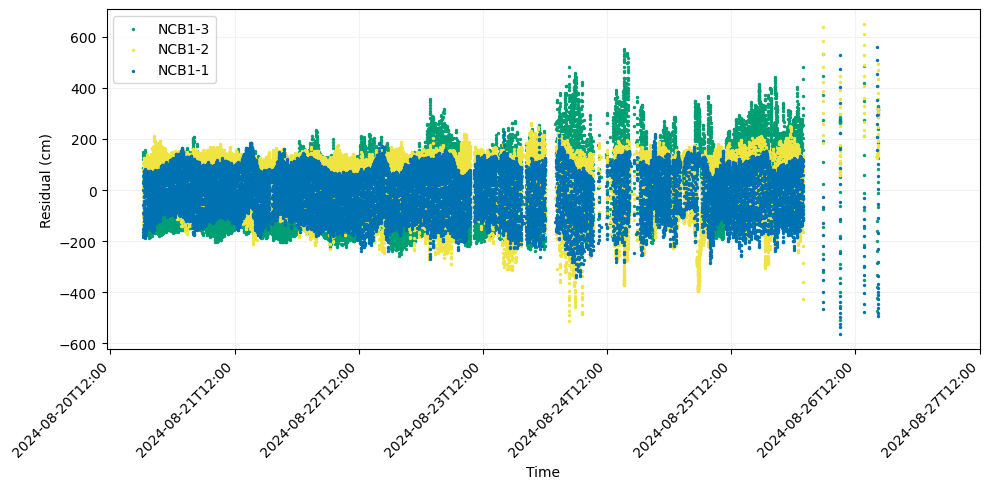

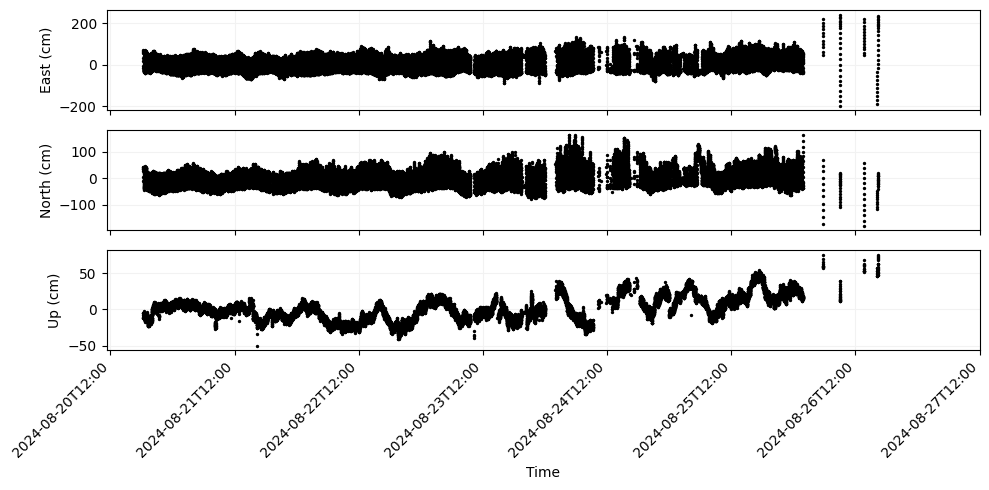

In [5]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

Before moving on, make sure to revise the configuration file so that the path to the `gps_solution` points to the unaltered input data file `../data/exercise-3/output/gps_solution.csv`.

## Sound Velocity Profile

In order to generate an accurate GNSS-A position, it is imperitive that the sound velocity profile at the array is well-constrained. Currently, GNATSS is configured to accept a single sound velocity profile that is usually constrained by a CTD profile. During the inversion, the solver calculates the harmonic mean sound velocity above each transponder in the array using this profile, which is used to model the TWTT using a straight-ray approximation.

In general, the sound velocity structure of the water column is more complicated than this simplified approach, but as long as this structure approximates a horizontally layered medium the horizontal position generated by the inversion should be fairly stable.

However, it is still important to have as accurate sound velocity information as possible. To demonstrate this, we have provided a series of "dummy" sound velocity profiles that have been modified by increasing the sound velocity value by 5 m/s at specific depths. This is a huge change, probably far larger than the variation that may be observed in real data, but should highlight the dependence of the inversion on accurate sound velocity information.

In order to run these examples, modify the configuration file `../data/exercise-3/NCB1_2024_config.yaml` so that the `sound_speed` path in the solver points to the modified sound velocity profile. We will examine three examples in which the sound velocity is modified throughout the entire profile at shallow depths, and near the seafloor, respectively.

### Full Profile

The first example we will examine is one in which the entire sound velocity profile is systematically increased by 5 m/s at all water depths. This profile is stored at `../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_fast`. In order to run this example, edit the configuration file so that the `sound_speed` path points to this file as below:

```
    sound_speed: #Assume 2-column text file with depth (m), sound velocity (m/s)
      path: ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_fast
```

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_fast
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_fast
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1486.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1486.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1486.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...
-

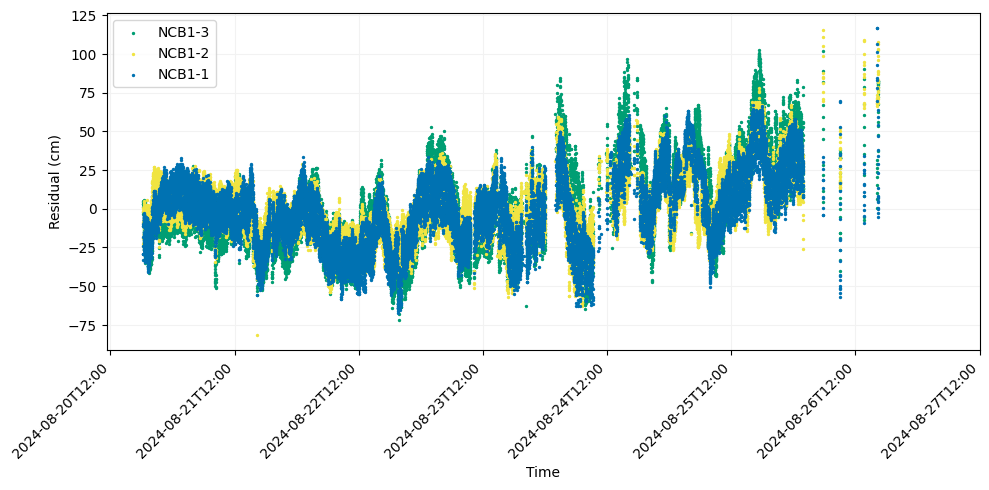

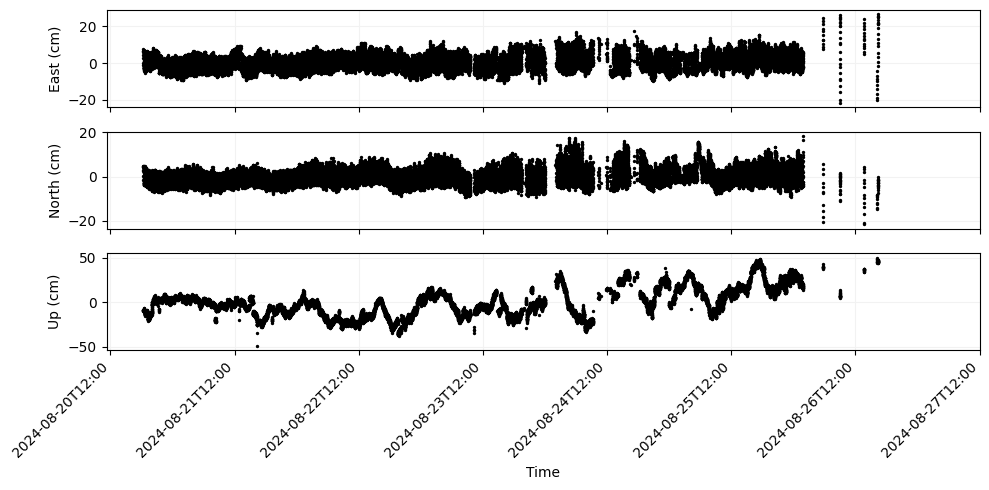

In [6]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

This result is quite a bit more interesting than the results with modified delay times because much of the structure in the residuals present in the refence solution is still present despite the eroneous CTD. The primary difference is that the residuals are "fuzzier" due to a higher noise level.

We will reiterate that this is a somewhat extreme case, but do not be decieved into thinking this solution is accurate despite the identifiable structure in the residuals closely resembling the reference solution. If you were to inspect the array offsets of the reference solution and this run with the modified CTD profile you would find a difference in the final position that is >10 cm.

### Upper Water Column

This example will process the data with a sound velocity profile modified that has increased velocities in the upper 300 m of the water column. Like the "Full Profile" example, velocities have been increased by 5 m/s. This is meant to simulate an extreme case of changing sound velocities in the shallow water above the thermocline, where we might nominally expect much of the oceanographic variation to occur.

This path to this profile is `../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_upper`. Modify the configuration file so that the `sound_speed` path points to this file, and then run the solver.

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_upper
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_upper
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1483.049 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1483.014 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1482.994 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...

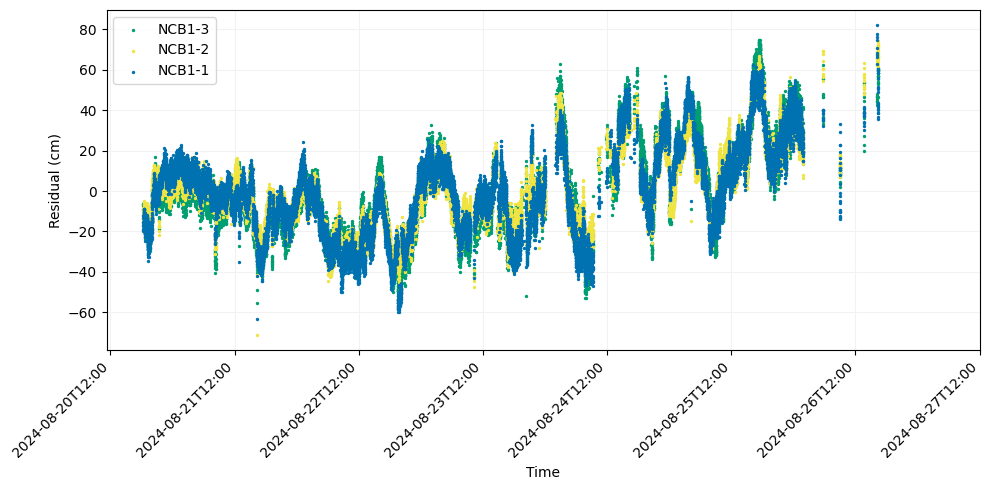

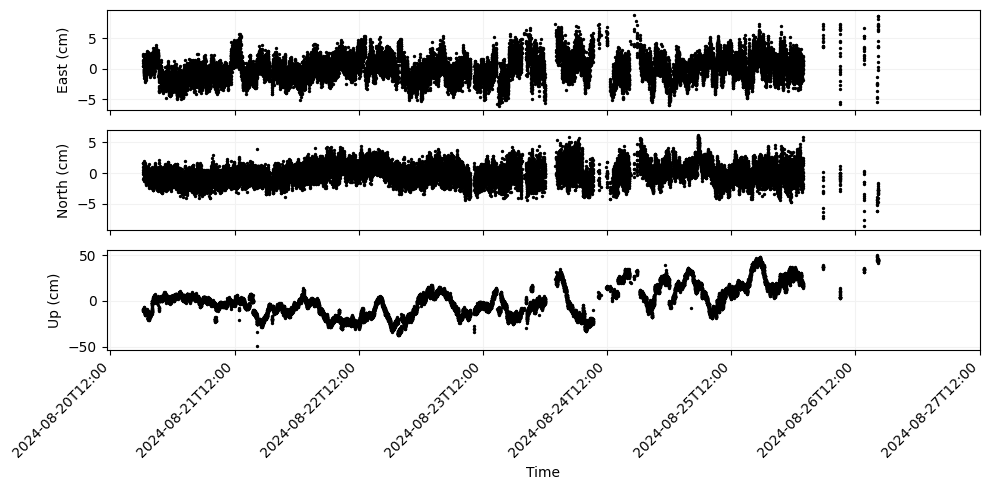

In [7]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

Overall, the differences between this solution and the reference solution are much more subtle compared to the example where the entire water column was modified. This is probably to be expected since the sound velocity change is much more localized in this example. However, the final solution has still been shifted a few cm compared to the reference solution.

### Lower Water Column

This final example features a profile where sound velocities were increased by 5 m/s if they were deeper than 1100m depth. The path to this profile is `../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_lower`. Update the `sound_speed` path in the configuration file to point to this profile and re-run the solver.

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_lower
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi_lower
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58017583 lon=-125.097547806 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.44 elevation=39.67
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.771 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.887 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...

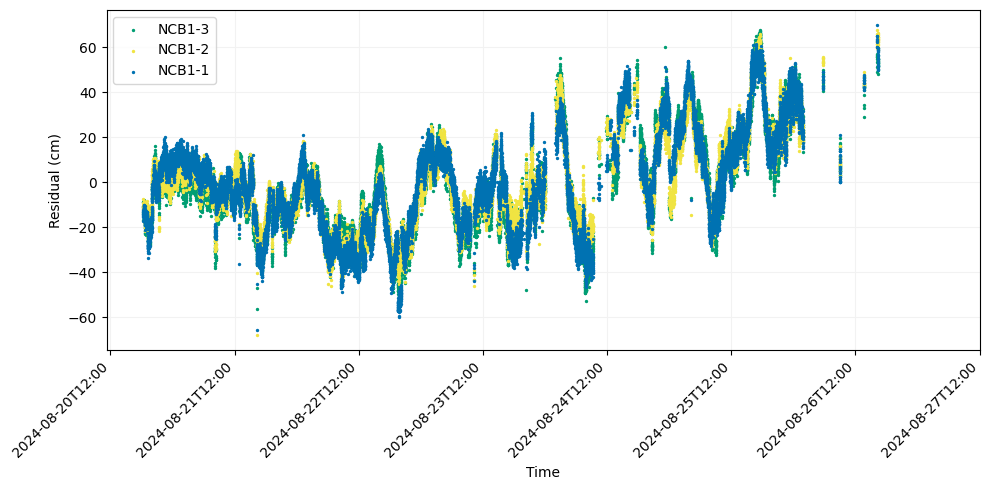

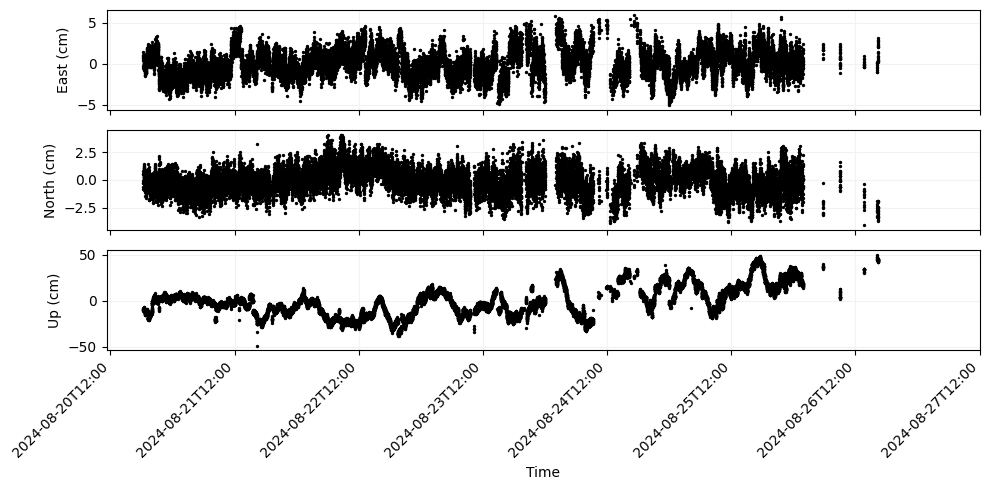

In [8]:
output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

If you were to only look at the residual plots, you may be tricked into thinking that this solution is similar to the reference solution. However, the transponder offsets are much different, even more so than was the case when the entire profile was modified. This is despite the fact that the segment of the profile spans <100m, far less than either of the other examples!

In a way we have cheated when creating this profile because the 1100m depth was chosen as a transition point specifically because one of the transponders in this array rests at a shallower depth and therefore would not see the effect of the altered sound velocity. However, this represents a "worst-case scenario" for the fixed-point GNSS-A processing that GNATSS performs whereby a deep body of water passes over one/some of the transponders and breaks the symmetry of the system we rely upon for the inversion.

### Sound Velocity Summary

In the previous example we have seen that changing the sound velocity profile can lead to significant biases in the final GNSS-A solution even when there is not a noticeable change in the residuals. To make this point a little more obvious, we have summarized the transponder offsets obtained using the various sound velocity profiles in the table below.

Note that this is likely site specific, but the main takeaway is that which part of the profile is changing is much more important than the change itself. GNATSS is particularly sensitive to changes in the lower water column. This segment of the water column is assumed to be fairly stable in most cases, but if that assumption were to break down it could lead to biased position estimate with no indication of anything wrong.

|          | East Offset (cm) | North Offset (cm) |
| -------- | --------------- | ---------------- |
| Reference Solution | 28.99 | -5.33 |
| Full Column | 8.55 | -8.7 |
| Upper Column | 28.75 | -2.05 |
| Lower Column | 14.26 | -11.87 |

Before moving on, revise the configuration file so that the `sound_speed` path points to the correct sound velocity profile at `../data/exercise-3/ctd/CTD_NCB1_Ch_Mi`.

## Transponder Locations

The final metadata we shall examine in the exercise are the *a priori* transponder locations. We have prepared a configuration file for this purpose, `../data/exercise-3/NCB1_2024_shifted_transponder_config.yaml`, which only differs from the reference configuration file by a small difference: the *a priori* location of the NCB1-3 transponder has been shifted north by 10m.

To see how this one small change has affected the final solution, run GNATSS as before but calling upon this altered configuration file.

Starting GNATSS ...
Gathering gps_solution at ../data/exercise-3/output/gps_solution.csv
Gathering sound_speed at ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading gps_solution from ../data/exercise-3/output/gps_solution.csv
Loading sound_speed from ../data/exercise-3/ctd/CTD_NCB1_Ch_Mi
Loading deletions from ../data/exercise-3/output/
Filtering out data outside of distance limit...
Pre-filtering data with fewer than 3 replies...
Computing harmonic mean...
lat=43.58026585 lon=-125.097547797 height=-1076.6562 alt=-1076.6562 internal_delay=0.08 sv_mean=1481.682 pxp_id='NCB1-3' azimuth=57.78 elevation=39.94
lat=43.566349513 lon=-125.097616709 height=-1116.0454 alt=-1116.0454 internal_delay=0.36 sv_mean=1481.695 pxp_id='NCB1-2' azimuth=-58.75 elevation=39.38
lat=43.57274798 lon=-125.115119432 height=-1140.9439 alt=-1140.9439 internal_delay=0.64 sv_mean=1481.704 pxp_id='NCB1-1' azimuth=-175.59 elevation=39.52
Finished computing harmonic mean
Preparing data inputs...
Perform solve...
--- 27243 e

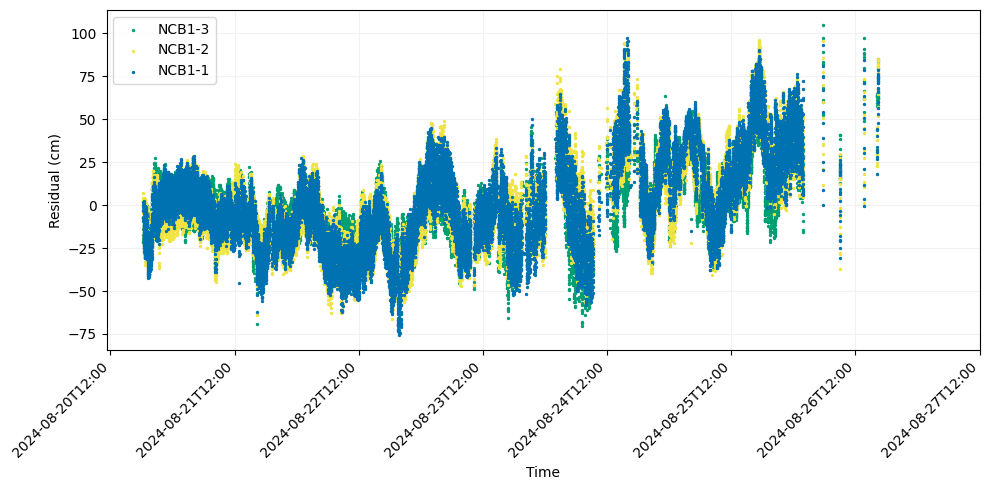

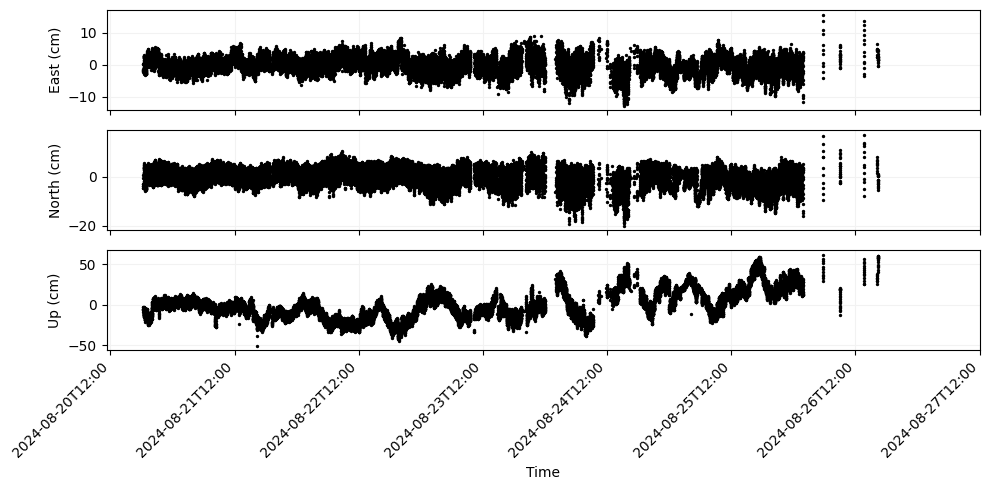

In [9]:
# Set input variables

config_yaml = "../data/exercise-3/NCB1_2024_shifted_transponder_config.yaml"
skip_posfilter = True

# Run GNATSS solver

output = run_gnatss(
    config_yaml,
    skip_posfilter=skip_posfilter
)

We can see that the residuals have been somewhat affected, and the transponder offsets are meters from the *a priori* locations.

**However, note how the offset is not 10m to the north!** This is because GNATSS assumes a rigid array geometry and constrains each transponder to have the same offset. In this example, only one transponder's *a priori* location was shifted and thus that was distributed to the other transponders as well.

The important thing to note here is that the error we introduced into the *a priori* location is small. The transponders can drift many tens of meters laterally from their drop points as they sink through the water column, so if you naively try to compute a GNSS-A position using the drop points as *a priori* you are liable to see much larger errors than occurred in this example. Because of this, it is incredibly important to triangulate the transponder locations as best as you can before running a GNSS-A survey so that you can approximate where the transponders actually are. Normally this is accomplished by directing the surface platform to conduct a "circle drive" around each transponder. This allows you to constrain the transponder location to the accuracy of a few decimeters, easily sufficient for GNSS-A positioning. From these triangulated transponder positions, you can compute the array center, defined not as the geometric array center but rather the point on the sea surface from which the TWTT to each transponder is equivalent.

Unfortunately, the full process for computing *a priori* transponder positions is beyond the scope of this exercise.